# CONNECT TO GOOGLE DRIVE  </br>
Make sure dependency ViolentImages_extended.zip is in the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import scipy.io
from scipy.io import loadmat
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
# breaking up the dataset into training and testing part
from sklearn.model_selection import train_test_split
# this library will return 4 items which are x_train,y_train, x_test and y_test

# Data Pre-processing + Dataset building
*Can skip this steps if already have dataset.csv dependency


In [4]:
# Unzip the ViolentImages_extended.zip file 
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/ViolentImages_extended.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset')

In [5]:
labels = loadmat('/content/Dataset/disturbing-tags_extended.mat') #the file needs to be uploaded or changed to from drive
labels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'FileList', 'Labels'])

In [6]:
type(labels['FileList']), labels['Labels'].shape, labels['FileList'].shape

(numpy.ndarray, (1, 5401), (1, 5401))

In [7]:
# If this cell fails, run the cell 2 steps above (loadmat) again then run this cell.
fileList = [item.flat[0] for item in labels['FileList'][0]]
labels = [item for item in labels['Labels'][0]]
data = np.vstack((fileList, labels)).T # the label array
columns = ['Filename','labels']
dataset = pd.DataFrame(data, columns=columns)

In [8]:
nonViolent = dataset[(dataset.labels == "1")]
nonViolentRemoved = nonViolent.iloc[:-800 , :]
violent = dataset[(dataset.labels == "2")]
print("Non violent total images : ", len(nonViolentRemoved.index))
print("Violent total images : ", len(violent.index))

datasetRemoved = (pd.concat([nonViolentRemoved,violent]))
datasetRemoved

Non violent total images :  2558
Violent total images :  2043


,Filename,labels
1,27.png,1
3,274.png,1
4,397.png,1
5,519.png,1
6,644.png,1
...,...,...
2590,5397.png,2
2591,5398.png,2
2592,5399.png,2
2593,5400.png,2


In [9]:
np.where(datasetRemoved.Filename == '27.png')

(array([0]),)

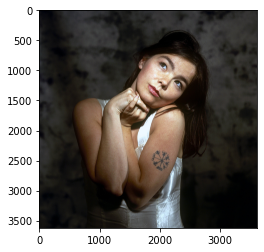

In [10]:
import imageio
# Reading the input image
img = imageio.imread("/content/Dataset/ViolentImages_addedBackground/1009.png") 

# image = plt.imread(img1_DIR)
pyplot.imshow(img)

In [ ]:
import PIL
import os
from PIL import Image

folderpath = "/content/Dataset/ViolentImages_addedBackground"

# Resizing the files to 50x50 pixels
for file in os.listdir(folderpath):
    f_img = folderpath + "/" + file
    img = Image.open(f_img)
    img = img.resize((50,50))
    img.save(f_img)

# We can run the cell above one more time to see the image resized to 50x50px

In [ ]:
# making folders for processing
violenceImages = "/content/violent"
nonViolenceImages = "/content/notViolent"

if not os.path.isdir(violenceImages):
  os.mkdir(violenceImages)
else:
  print("Already made")

if not os.path.isdir(nonViolenceImages):
  os.mkdir(nonViolenceImages)
else:
  print("Already made")


In [ ]:
if len(os.listdir(violenceImages)) == 0 and len(os.listdir(nonViolenceImages)) == 0:
  import shutil

  for file in os.listdir(folderpath):
    temp = datasetRemoved[(datasetRemoved.Filename == file)]
    if (len(temp) != 0):
      label = int(temp.iloc[0]['labels'])
      f_img = folderpath + "/" + file

      if (label == 1): 
        shutil.copyfile(f_img, nonViolenceImages + "/" + file) 
      elif (label == 2):
        shutil.copyfile(f_img, violenceImages + "/" + file)
      else:
        print("Something wrong")
else:
  print("Images already splitted")

In [ ]:
import csv
file = open ("violenceDataset.csv","a") 
header = ['violence','pixels','usage']
data=[]
with open('violenceDataset.csv', 'a', encoding='UTF-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)


In [ ]:
# Dont run this twice
for file in os.listdir(violenceImages):
  im = Image.open(violenceImages + "/" + file, 'r')
  pix_val = list(im.getdata())
  pix_val_flat = [x for sets in pix_val for x in sets]

  join_pixels = " ".join(str(i) for i in pix_val_flat)

  dataInput=[0, join_pixels,'Training'] #the csv file line
  data.append(dataInput)

In [ ]:
# Dont run this twice
for file in os.listdir(nonViolenceImages):
  im = Image.open(nonViolenceImages + "/" + file, 'r')
  pix_val = list(im.getdata())
  pix_val_flat = [x for sets in pix_val for x in sets]

  join_pixels = " ".join(str(i) for i in pix_val_flat)

  dataInput=[1, join_pixels,'Training'] #the csv file line
  data.append(dataInput)

In [ ]:
shuffledDataset = np.random.RandomState(seed=45345).permutation(data)


columns = ['Label', 'Pixels', 'Set']
df = pd.DataFrame(shuffledDataset, columns=columns)
df

In [ ]:
from tqdm.notebook import tqdm

for index, row in tqdm(df.iterrows()):
    dataInput=[row['Label'], row['Pixels'],row['Set']] #the csv file line

    with open('violenceDataset.csv', 'a', encoding='UTF-8', newline='') as f:
      writer = csv.writer(f)
      writer.writerow(dataInput)

In [ ]:
source = '/content/violenceDataset.csv'
destination = '/content/drive/MyDrive/vioDetect/violenceDataset.csv'

if not os.path.exists('/content/drive/MyDrive/vioDetect'):
  os.mkdir('/content/drive/MyDrive/vioDetect')
else:
  print("Folder already made")

if not os.path.exists('/content/drive/MyDrive/vioDetect/violenceDataset.csv'):
  # Move the content of 
  # source to destination 
  dest = shutil.move(source, destination)
else : print("File violenceDataset already exist")



# Building Model
make sure you have the violenceDataset.csv already in your google drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/violence_detection/vioDetect/violenceDataset.csv')


In [ ]:
df.violence.unique()

array([0, 1])

In [ ]:
label_to_text = {0:'violence', 1:'non-violence'}

In [ ]:
np.array(df.pixels.loc[0].split(' ')).reshape(75,100)

array([['0', '0', '0', ..., '71', '71', '78'],
       ['72', '74', '82', ..., '107', '157', '155'],
       ['153', '170', '169', ..., '0', '0', '0'],
       ...,
       ['0', '0', '0', ..., '65', '69', '150'],
       ['151', '153', '153', ..., '24', '13', '12'],
       ['15', '23', '22', ..., '0', '0', '0']], dtype='<U3')

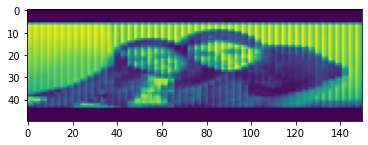

In [ ]:
pyplot.imshow(np.array(df.pixels.loc[4].split(' ')).reshape(50,150).astype('float'))

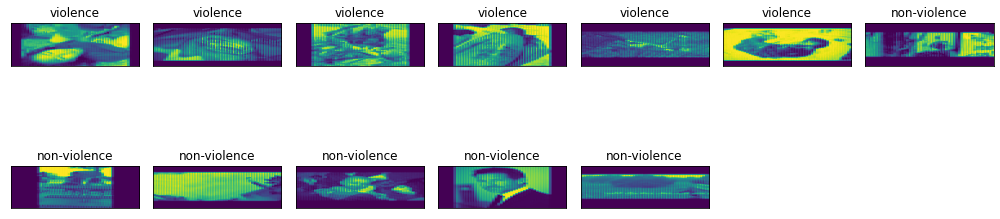

In [ ]:
# to look up all the images just for the visualization part.
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.violence.unique()):
    for j in range(6):
        px = df[df.violence==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(50, 150).astype('float32')
        k += 1
        # here generate the figure of 7 x 7.
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [ ]:
img_array = df.pixels.apply(lambda x : np.array(x.split(' ')).reshape(50, 150,1).astype('float32'))

In [ ]:
img_array = np.stack(img_array,axis=0)

In [ ]:
img_array.shape

(3066, 50, 150, 1)

In [ ]:
labels = df.violence.values
print(labels)

[0 1 1 ... 0 0 1]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img_array,labels,test_size = .1)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2759, 50, 150, 1), (2759,), (307, 50, 150, 1), (307,))

In [ ]:
x_train = x_train/255
x_test= x_test/255

In [ ]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(50,150,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu', input_shape=(50,150,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu', input_shape=(50,150,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(128,activation='relu'),
                                        tf.keras.layers.Dense(2,activation = 'softmax')
])

In [ ]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 148, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 74, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 74, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 36, 64)       0         
 2D)                                                             
                                                        

In [ ]:
basemodel.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=.0001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ['accuracy'])

In [ ]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [ ]:
file_name = 'violence_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back= tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_feq='epoch',
                                             save_best_only=True,
                                             save_weight_only=False,
                                             mode='max')

In [ ]:
history = basemodel.fit(x_train,y_train,epochs=20,validation_split=.1,callbacks=call_back)

Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.6931
Epoch 00001: val_accuracy improved from -inf to 0.33696, saving model to checkpoint/violence_model.h5
78/78 [==============================] - 33s 410ms/step - loss: 0.6815 - accuracy: 0.6931 - val_loss: 0.7704 - val_accuracy: 0.3370
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8373
Epoch 00002: val_accuracy did not improve from 0.33696
78/78 [==============================] - 32s 406ms/step - loss: 0.3461 - accuracy: 0.8373 - val_loss: 0.9173 - val_accuracy: 0.3370
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9299
Epoch 00003: val_accuracy did not improve from 0.33696
78/78 [==============================] - 32s 404ms/step - loss: 0.1983 - accuracy: 0.9299 - val_loss: 1.0235 - val_accuracy: 0.3370
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9694
Epoch 00004: val

actual label is non-violence
predicted label is non-violence


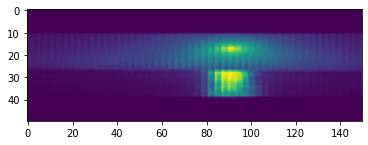

In [ ]:
final_model = tf.keras.models.load_model("/content/"+checkpoint_path)
from IPython.display import clear_output
import time
for k in range(20):
  print(f'actual label is {label_to_text[y_test[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(x_test[k],0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot.imshow(x_test[k].reshape((50,150)))
  pyplot.show()
  time.sleep(5)
  clear_output(wait=True)

# Model evaluation

In [ ]:
from sklearn.metrics import accuracy_score

Confusion matrix

In [ ]:
plotdata = history.history
plotdata

{'accuracy': [0.6272141933441162,
  0.7882447838783264,
  0.8789586424827576,
  0.9414921998977661,
  0.971551239490509,
  0.9863123893737793,
  0.9916800856590271,
  0.9951691031455994,
  0.9973161816596985,
  0.998389720916748,
  0.9994632601737976,
  0.999194860458374,
  1.0,
  0.999194860458374,
  0.999194860458374,
  1.0,
  1.0,
  1.0,
  0.9997316002845764,
  0.9997316002845764],
 'loss': [0.7666577696800232,
  0.4611526131629944,
  0.30560633540153503,
  0.1884070783853531,
  0.1160038635134697,
  0.07268937677145004,
  0.04618178308010101,
  0.028209291398525238,
  0.02079261653125286,
  0.012247255071997643,
  0.007223131600767374,
  0.0048411255702376366,
  0.0030311238951981068,
  0.002714883303269744,
  0.002358656143769622,
  0.001201455481350422,
  0.0007245598826557398,
  0.0004643843276426196,
  0.0013315867399796844,
  0.0007944753742776811],
 'val_accuracy': [0.5024154782295227,
  0.5024154782295227,
  0.6594203114509583,
  0.6642512083053589,
  0.6666666865348816,
  0

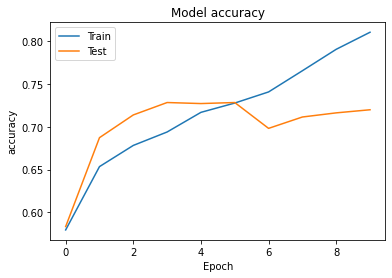

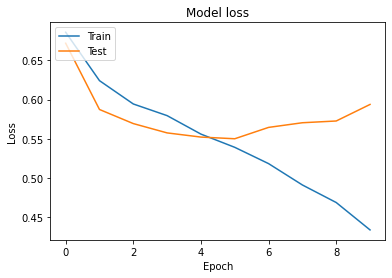

In [ ]:
pyplot.plot(plotdata['accuracy'])
pyplot.plot(plotdata['val_accuracy'])
pyplot.title('Model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.show()

pyplot.plot(plotdata['loss'])
pyplot.plot(plotdata['val_loss'])
pyplot.title('Model loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper left')
pyplot.show()

In [ ]:
from sklearn.metrics import accuracy_score
pred = basemodel.predict(x_test)
y_pred = np.argmax(pred,axis=1)

accuracy_score(y_test,y_pred)


0.7158351409978309

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1eae77c10>)

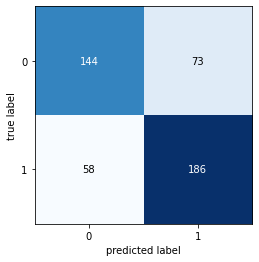

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 

mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat)



# Model Experimentation
Insert your own images and test it out!

In [ ]:
#if you have the h5 file of model you can insert

final_model = tf.keras.models.load_model(file_name_model2)

In [ ]:
playing_folderpath = "/content/playingimages"
playingprocessed_folderpath = "/content/playingimages/processedimages"

try:
  os.mkdir(playing_folderpath)
except:
  pass
try:
  os.mkdir(playingprocessed_folderpath)
except:
  pass


<h2>Put all your images in the "playingimages" folder</h2


In [ ]:
import PIL
from PIL import Image

for fname in os.listdir(playing_folderpath):
    path = os.path.join(playing_folderpath, fname)
    if not os.path.isdir(path):
      f_img = playing_folderpath + "/" + fname
      img = Image.open(f_img)
      resizedimg = img.resize((50,50))
      resizedimg.save(playingprocessed_folderpath + "/" + fname)
      print(fname)


dont want.png
Cat-1.jpg
DSC_5540045.jpg
https___data.amirite.com_posts_16_02_405b2e8b8dba.jpg


In [ ]:
os.listdir(playingprocessed_folderpath)

['dont want.png',
 'Cat-1.jpg',
 'DSC_5540045.jpg',
 'https___data.amirite.com_posts_16_02_405b2e8b8dba.jpg',
 '.ipynb_checkpoints']

In [ ]:
playingimages = []
for playfile in os.listdir(playingprocessed_folderpath):
  if playfile != '.ipynb_checkpoints': 
    im = Image.open(playingprocessed_folderpath + "/" + playfile, 'r')
    pix_val = list(im.getdata())
    pix_val_flat = [x for sets in pix_val for x in sets]
    join_pixels = " ".join(str(i) for i in pix_val_flat)
    dataInput=[join_pixels]
    playingimages.append(dataInput)

columns = ['Label']
playingdf = pd.DataFrame(playingimages, columns=columns)
playingdf

,Label
0,189 156 3 190 157 3 191 159 3 193 161 2 194 16...
1,0 0 0 0 0 0 0 0 0 0 0 0 54 55 53 74 75 70 50 5...
2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,115 110 106 118 113 107 115 108 100 131 122 11...
4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
5,254 254 254 254 254 254 254 254 254 254 254 25...
6,28 24 25 12 8 9 9 3 3 12 2 0 11 0 0 17 0 0 112...


In [ ]:
playing_img_array = playingdf.Label.apply(lambda x : np.array(x.split(' ')).reshape(50, 150,1).astype('float32'))

In [ ]:
playing_img_array = np.stack(playing_img_array,axis=0)

In [ ]:
playing_img_array.shape

(7, 50, 150, 1)

predicted label is non-violence


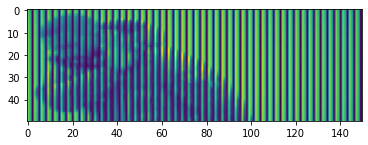

predicted label is non-violence


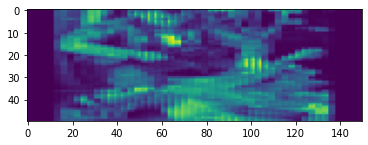

predicted label is non-violence


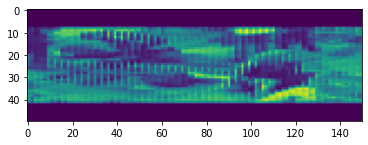

predicted label is non-violence


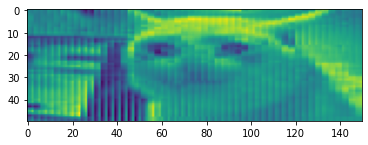

predicted label is non-violence


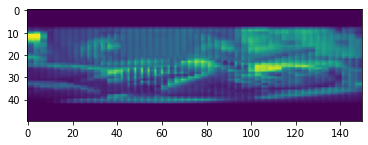

predicted label is non-violence


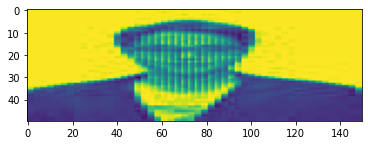

predicted label is non-violence


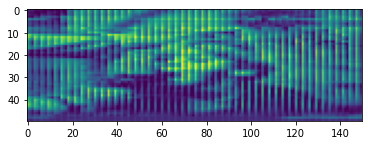

In [ ]:
final_model = tf.keras.models.load_model("/content/"+checkpoint_path)
for k in playing_img_array:
  predicted_class = final_model.predict(tf.expand_dims(k,0)).argmax()
  print(f'predicted label is {label_to_text[predicted_class]}')
  pyplot.imshow(k.reshape((50,150)))
  pyplot.show()